### Code to check extents of test and train dataset, with overlaps

In [3]:
import os
import geopandas as gpd
import pandas as pd
from pathlib import Path
from collections import defaultdict
import warnings

In [4]:
base_path = '/gws/nopw/j04/iecdt/amorgan/benchmark_data_CB/ICE-BENCH/extents_shp'
folders = ['extents-test', 'extents-training']
satellites = ['Sentinel-1', 'ERS', 'Envisat']

def load_all_scenes(base_path, folders, satellites):
    """Load all shapefiles with metadata about their source"""
    scenes = []
    
    for folder in folders:
        for satellite in satellites:
            sat_path = os.path.join(base_path, folder, satellite)
            
            if not os.path.exists(sat_path):
                print(f"Warning: Path does not exist: {sat_path}")
                continue
            
            shp_files = [f for f in os.listdir(sat_path) if f.endswith('.shp')]
            print(f"Loading {len(shp_files)} scenes from {folder}/{satellite}")
            
            for shp_file in shp_files:
                file_path = os.path.join(sat_path, shp_file)
                try:
                    gdf = gpd.read_file(file_path)
                    
                    # Store each feature with metadata
                    for idx, row in gdf.iterrows():
                        scenes.append({
                            'geometry': row.geometry,
                            'satellite': satellite,
                            'folder': folder,
                            'filename': shp_file,
                            'full_path': file_path,
                            'scene_id': f"{folder}/{satellite}/{shp_file}"
                        })
                except Exception as e:
                    print(f"  Error loading {shp_file}: {e}")
    
    return pd.DataFrame(scenes)

def find_overlaps(scenes_df, reference_satellite='Sentinel-1'):
    """Find all overlapping scenes, starting with reference satellite"""
    
    # Separate reference scenes from others
    ref_scenes = scenes_df[scenes_df['satellite'] == reference_satellite].copy()
    other_scenes = scenes_df[scenes_df['satellite'] != reference_satellite].copy()
    
    print(f"\n{'='*80}")
    print(f"OVERLAP ANALYSIS")
    print(f"{'='*80}")
    print(f"Reference: {len(ref_scenes)} {reference_satellite} scenes")
    print(f"Comparing against: {len(other_scenes)} other scenes")
    
    overlap_results = []
    
    # For each reference scene, find all overlapping scenes
    for ref_idx, ref_scene in ref_scenes.iterrows():
        ref_geom = ref_scene['geometry']
        ref_id = ref_scene['scene_id']
        
        overlapping_scenes = []
        
        # Check against all other reference scenes (including same satellite)
        for comp_idx, comp_scene in ref_scenes.iterrows():
            if ref_idx == comp_idx:  # Skip self
                continue
            
            comp_geom = comp_scene['geometry']
            
            # Check if geometries overlap
            if ref_geom.intersects(comp_geom):
                intersection = ref_geom.intersection(comp_geom)
                overlap_area = intersection.area if hasattr(intersection, 'area') else 0
                
                overlapping_scenes.append({
                    'overlapping_scene_id': comp_scene['scene_id'],
                    'overlapping_satellite': comp_scene['satellite'],
                    'overlapping_folder': comp_scene['folder'],
                    'overlapping_filename': comp_scene['filename'],
                    'overlap_area': overlap_area,
                    'overlap_type': 'same_satellite'
                })
        
        # Check against other satellites
        for other_idx, other_scene in other_scenes.iterrows():
            other_geom = other_scene['geometry']
            
            if ref_geom.intersects(other_geom):
                intersection = ref_geom.intersection(other_geom)
                overlap_area = intersection.area if hasattr(intersection, 'area') else 0
                
                overlapping_scenes.append({
                    'overlapping_scene_id': other_scene['scene_id'],
                    'overlapping_satellite': other_scene['satellite'],
                    'overlapping_folder': other_scene['folder'],
                    'overlapping_filename': other_scene['filename'],
                    'overlap_area': overlap_area,
                    'overlap_type': 'different_satellite'
                })
        
        # Store results
        if overlapping_scenes:
            overlap_results.append({
                'reference_scene_id': ref_id,
                'reference_satellite': ref_scene['satellite'],
                'reference_folder': ref_scene['folder'],
                'reference_filename': ref_scene['filename'],
                'num_overlaps': len(overlapping_scenes),
                'overlapping_scenes': overlapping_scenes
            })
    
    return overlap_results

def print_overlap_summary(overlap_results):
    """Print summary statistics of overlaps"""
    
    print(f"\n{'='*80}")
    print(f"OVERLAP SUMMARY")
    print(f"{'='*80}\n")
    
    if not overlap_results:
        print("No overlaps found!")
        return
    
    # Overall statistics
    total_scenes_with_overlaps = len(overlap_results)
    total_overlaps = sum(r['num_overlaps'] for r in overlap_results)
    
    print(f"Scenes with overlaps: {total_scenes_with_overlaps}")
    print(f"Total overlap instances: {total_overlaps}")
    print(f"Average overlaps per scene: {total_overlaps/total_scenes_with_overlaps:.2f}")
    
    # Breakdown by satellite
    print(f"\n{'='*80}")
    print("OVERLAPS BY SATELLITE")
    print(f"{'='*80}\n")
    
    satellite_overlaps = defaultdict(lambda: defaultdict(int))
    
    for result in overlap_results:
        ref_sat = result['reference_satellite']
        for overlap in result['overlapping_scenes']:
            overlap_sat = overlap['overlapping_satellite']
            satellite_overlaps[ref_sat][overlap_sat] += 1
    
    for ref_sat, overlaps in satellite_overlaps.items():
        print(f"{ref_sat} overlaps with:")
        for overlap_sat, count in overlaps.items():
            print(f"  - {overlap_sat}: {count} overlaps")
        print()
    
    # Detailed listing
    print(f"\n{'='*80}")
    print("DETAILED OVERLAP LISTING")
    print(f"{'='*80}\n")
    
    for result in overlap_results:
        print(f"Scene: {result['reference_filename']}")
        print(f"  Location: {result['reference_folder']}/{result['reference_satellite']}")
        print(f"  Number of overlaps: {result['num_overlaps']}")
        print(f"  Overlapping with:")
        
        for overlap in result['overlapping_scenes']:
            print(f"    - {overlap['overlapping_filename']}")
            print(f"      ({overlap['overlapping_folder']}/{overlap['overlapping_satellite']})")
            if overlap['overlap_area'] > 0:
                print(f"      Overlap area: {overlap['overlap_area']:.2f} sq units")
        print()

def export_overlap_csv(overlap_results, output_path='overlap_analysis.csv'):
    """Export overlap results to CSV"""
    
    rows = []
    for result in overlap_results:
        for overlap in result['overlapping_scenes']:
            rows.append({
                'reference_scene': result['reference_filename'],
                'reference_satellite': result['reference_satellite'],
                'reference_folder': result['reference_folder'],
                'overlapping_scene': overlap['overlapping_filename'],
                'overlapping_satellite': overlap['overlapping_satellite'],
                'overlapping_folder': overlap['overlapping_folder'],
                'overlap_area': overlap['overlap_area'],
                'overlap_type': overlap['overlap_type']
            })
    
    df = pd.DataFrame(rows)
    df.to_csv(output_path, index=False)
    print(f"\nOverlap details exported to: {output_path}")
    return df

# Main execution
print("Starting overlap analysis...")
print(f"{'='*80}\n")

# Load all scenes
scenes_df = load_all_scenes(base_path, folders, satellites)
print(f"\nTotal scenes loaded: {len(scenes_df)}")

# Find overlaps
overlap_results = find_overlaps(scenes_df, reference_satellite='Sentinel-1')

# Print summary
print_overlap_summary(overlap_results)

# Export to CSV
overlap_df = export_overlap_csv(overlap_results)

print(f"\n{'='*80}")
print("Analysis complete!")
print(f"{'='*80}")

Starting overlap analysis...

Loading 27 scenes from extents-test/Sentinel-1
Loading 8 scenes from extents-test/ERS
Loading 3 scenes from extents-test/Envisat
Loading 81 scenes from extents-training/Sentinel-1
Loading 33 scenes from extents-training/ERS
Loading 10 scenes from extents-training/Envisat

Total scenes loaded: 162

OVERLAP ANALYSIS
Reference: 108 Sentinel-1 scenes
Comparing against: 54 other scenes

OVERLAP SUMMARY

Scenes with overlaps: 103
Total overlap instances: 1005
Average overlaps per scene: 9.76

OVERLAPS BY SATELLITE

Sentinel-1 overlaps with:
  - Sentinel-1: 768 overlaps
  - ERS: 189 overlaps
  - Envisat: 48 overlaps


DETAILED OVERLAP LISTING

Scene: S1A_20141027_HH_EW_GRDM_F2A9.shp
  Location: extents-test/Sentinel-1
  Number of overlaps: 3
  Overlapping with:
    - S1A_20161218_HH_EW_GRDM_F567.shp
      (extents-test/Sentinel-1)
      Overlap area: 4379334620.37 sq units
    - S1A_20191026_HH_EW_GRDM_EC5A.shp
      (extents-test/Sentinel-1)
      Overlap area: 

### plot these most overlaps

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import to_rgba
import cartopy.crs as ccrs
import cartopy.feature as cfeature

/tmp/ipykernel_3110495/796478750.py:271: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.04, 1, 0.96])



Figure saved to: overlap_regions_antarctic_stereo_zoomed.png


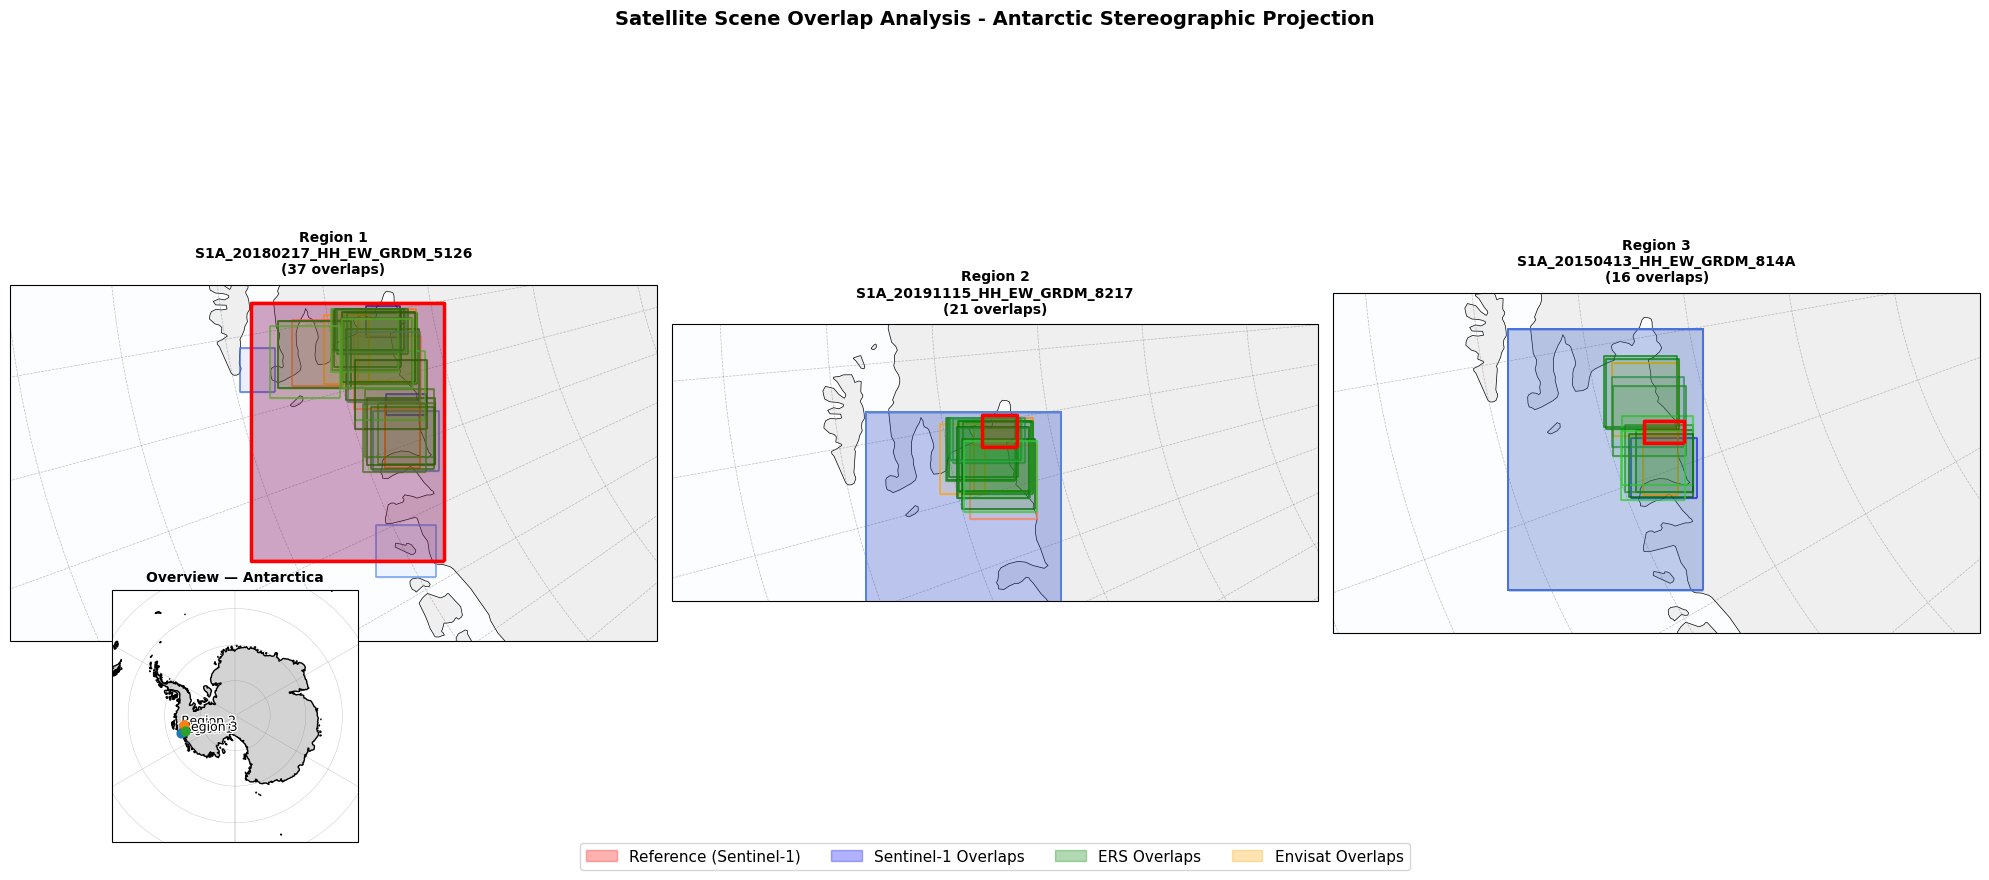

In [7]:
base_path = '/gws/nopw/j04/iecdt/amorgan/benchmark_data_CB/ICE-BENCH/extents_shp'

# Define the three interesting regions with their overlapping scenes
regions = {
    'Region 1': {
        'reference': {
            'folder': 'extents-training',
            'satellite': 'Sentinel-1',
            'filename': 'S1A_20180217_HH_EW_GRDM_5126.shp'
        },
        'overlapping': [
            # Sentinel-1
            ('extents-test', 'Sentinel-1', 'S1A_20150413_HH_EW_GRDM_814A.shp'),
            ('extents-test', 'Sentinel-1', 'S1A_20191115_HH_EW_GRDM_8217.shp'),
            ('extents-test', 'Sentinel-1', 'S1A_20200928_HH_EW_GRDM_34F1.shp'),
            ('extents-test', 'Sentinel-1', 'S1A_20210807_HH_EW_GRDM_3E5B.shp'),
            ('extents-test', 'Sentinel-1', 'S1A_20210830_HH_EW_GRDM_9947.shp'),
            ('extents-training', 'Sentinel-1', 'S1A_20170610_HH_EW_GRDM_D8CF.shp'),
            ('extents-training', 'Sentinel-1', 'S1A_20170926_HH_EW_GRDM_E04F.shp'),
            ('extents-training', 'Sentinel-1', 'S1A_20180921_HH_EW_GRDM_8801.shp'),
            # Envisat
            ('extents-test', 'Envisat', 'ENV_20080824_VV_074349.shp'),
            ('extents-training', 'Envisat', 'ENV_20060205_VV_133956.shp'),
            ('extents-training', 'Envisat', 'ENV_20070528_VV_134839.shp'),
            ('extents-training', 'Envisat', 'ENV_20090623_VV_135640.shp'),
            ('extents-training', 'Envisat', 'ENV_20100301_VV_140832.shp'),
            # ERS
            ('extents-training', 'ERS', 'ERS_19950122_VV_199501.shp'),
            ('extents-training', 'ERS', 'ERS_19951107_VV_199511.shp'),
            ('extents-training', 'ERS', 'ERS_19960214_VV_199602.shp'),
            ('extents-training', 'ERS', 'ERS_19960323_VV_199603.shp'),
            ('extents-training', 'ERS', 'ERS_19961029_VV_142649.shp'),
            ('extents-training', 'ERS', 'ERS_19961029_VV_199610.shp'),
            ('extents-training', 'ERS', 'ERS_19970305_VV_199703.shp'),
            ('extents-training', 'ERS', 'ERS_19990219_VV_199902.shp'),
            ('extents-training', 'ERS', 'ERS_20000513_VV_200005.shp'),
            ('extents-training', 'ERS', 'ERS_20020105_VV_200201.shp'),
            ('extents-training', 'ERS', 'ERS_20020209_VV_200202.shp'),
            ('extents-training', 'ERS', 'ERS_20020415_VV_200204.shp'),
            ('extents-training', 'ERS', 'ERS_20020624_VV_200206.shp'),
            ('extents-training', 'ERS', 'ERS_20020729_VV_200207.shp'),
            ('extents-training', 'ERS', 'ERS_20020907_VV_200209.shp'),
            ('extents-training', 'ERS', 'ERS_20021012_VV_200210.shp'),
            ('extents-training', 'ERS', 'ERS_20021103_VV_200211.shp'),
            ('extents-training', 'ERS', 'ERS_20021122_VV_200211.shp'),
            ('extents-training', 'ERS', 'ERS_20021227_VV_200212.shp'),
            ('extents-training', 'ERS', 'ERS_20030115_VV_200301.shp'),
            ('extents-training', 'ERS', 'ERS_20051003_VV_200510.shp'),
            ('extents-training', 'ERS', 'ERS_20100520_VV_201005.shp'),
            ('extents-training', 'ERS', 'ERS_20101128_VV_201011.shp'),
            ('extents-training', 'ERS', 'ERS_20110113_VV_201101.shp'),
        ]
    },
    'Region 2': {
        'reference': {
            'folder': 'extents-test',
            'satellite': 'Sentinel-1',
            'filename': 'S1A_20191115_HH_EW_GRDM_8217.shp'
        },
        'overlapping': [
            # Sentinel-1
            ('extents-training', 'Sentinel-1', 'S1A_20170610_HH_EW_GRDM_D8CF.shp'),
            ('extents-training', 'Sentinel-1', 'S1A_20170926_HH_EW_GRDM_E04F.shp'),
            ('extents-training', 'Sentinel-1', 'S1A_20180217_HH_EW_GRDM_5126.shp'),
            ('extents-training', 'Sentinel-1', 'S1A_20180921_HH_EW_GRDM_8801.shp'),
            # Envisat
            ('extents-test', 'Envisat', 'ENV_20080824_VV_074349.shp'),
            ('extents-training', 'Envisat', 'ENV_20060205_VV_133956.shp'),
            ('extents-training', 'Envisat', 'ENV_20070528_VV_134839.shp'),
            # ERS
            ('extents-training', 'ERS', 'ERS_19950122_VV_199501.shp'),
            ('extents-training', 'ERS', 'ERS_19951107_VV_199511.shp'),
            ('extents-training', 'ERS', 'ERS_19960323_VV_199603.shp'),
            ('extents-training', 'ERS', 'ERS_20020105_VV_200201.shp'),
            ('extents-training', 'ERS', 'ERS_20020209_VV_200202.shp'),
            ('extents-training', 'ERS', 'ERS_20020415_VV_200204.shp'),
            ('extents-training', 'ERS', 'ERS_20020624_VV_200206.shp'),
            ('extents-training', 'ERS', 'ERS_20020729_VV_200207.shp'),
            ('extents-training', 'ERS', 'ERS_20020907_VV_200209.shp'),
            ('extents-training', 'ERS', 'ERS_20021012_VV_200210.shp'),
            ('extents-training', 'ERS', 'ERS_20021103_VV_200211.shp'),
            ('extents-training', 'ERS', 'ERS_20021122_VV_200211.shp'),
            ('extents-training', 'ERS', 'ERS_20021227_VV_200212.shp'),
            ('extents-training', 'ERS', 'ERS_20030115_VV_200301.shp'),
        ]
    },
    'Region 3': {
        'reference': {
            'folder': 'extents-test',
            'satellite': 'Sentinel-1',
            'filename': 'S1A_20150413_HH_EW_GRDM_814A.shp'
        },
        'overlapping': [
            # Sentinel-1
            ('extents-test', 'Sentinel-1', 'S1A_20200928_HH_EW_GRDM_34F1.shp'),
            ('extents-training', 'Sentinel-1', 'S1A_20170610_HH_EW_GRDM_D8CF.shp'),
            ('extents-training', 'Sentinel-1', 'S1A_20170926_HH_EW_GRDM_E04F.shp'),
            ('extents-training', 'Sentinel-1', 'S1A_20180217_HH_EW_GRDM_5126.shp'),
            ('extents-training', 'Sentinel-1', 'S1A_20180921_HH_EW_GRDM_8801.shp'),
            # Envisat
            ('extents-training', 'Envisat', 'ENV_20070528_VV_134839.shp'),
            ('extents-training', 'Envisat', 'ENV_20100301_VV_140832.shp'),
            # ERS
            ('extents-training', 'ERS', 'ERS_19951107_VV_199511.shp'),
            ('extents-training', 'ERS', 'ERS_19960214_VV_199602.shp'),
            ('extents-training', 'ERS', 'ERS_19970305_VV_199703.shp'),
            ('extents-training', 'ERS', 'ERS_19990219_VV_199902.shp'),
            ('extents-training', 'ERS', 'ERS_20000513_VV_200005.shp'),
            ('extents-training', 'ERS', 'ERS_20030115_VV_200301.shp'),
            ('extents-training', 'ERS', 'ERS_20051003_VV_200510.shp'),
            ('extents-training', 'ERS', 'ERS_20100520_VV_201005.shp'),
            ('extents-training', 'ERS', 'ERS_20101128_VV_201011.shp'),
        ]
    }
}

def load_shapefile(folder, satellite, filename):
    """Load a single shapefile"""
    file_path = os.path.join(base_path, folder, satellite, filename)
    try:
        gdf = gpd.read_file(file_path)
        return gdf
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return None
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import patheffects
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Create Antarctic Stereographic projection for detailed plots
antarctic_proj = ccrs.SouthPolarStereo()

# Helper to get centroid lon/lat (EPSG:4326)
def get_centroid_lonlat(gdf):
    """Return (lon, lat) centroid of the GeoDataFrame in EPSG:4326."""
    gdf4326 = gdf.to_crs(epsg=4326)
    centroid = gdf4326.geometry.unary_union.centroid
    return centroid.x, centroid.y

# Prepare centroids for all regions (lon/lat)
region_centroids = {}
for region_name, region_data in regions.items():
    ref_gdf_orig = load_shapefile(
        region_data['reference']['folder'],
        region_data['reference']['satellite'],
        region_data['reference']['filename']
    )
    if ref_gdf_orig is None:
        print(f"Warning: could not load reference for {region_name} for centroid")
        continue
    lon, lat = get_centroid_lonlat(ref_gdf_orig)
    region_centroids[region_name] = (lon, lat)

# Create figure: 3 subplots (detailed) + one inset Antarctic overview
fig = plt.figure(figsize=(20, 9))

# Parameters to control "zoom out"
# Larger delta_deg => more zoomed-out (shows larger area around the scene)
delta_deg_default = 6.0   # try 6; set to 15 or 30 to zoom out more

for idx, (region_name, region_data) in enumerate(regions.items(), 1):
    ax = fig.add_subplot(1, 3, idx, projection=antarctic_proj)

    # --- plot the same as before but with small changes to extent handling ---
    # Load reference as original (we'll reproject below)
    ref_gdf = load_shapefile(
        region_data['reference']['folder'],
        region_data['reference']['satellite'],
        region_data['reference']['filename']
    )
    if ref_gdf is None:
        ax.set_title(f"{region_name}\n(reference missing)")
        continue

    # reproject to Antarctic stereographic for plotting features in each subplot
    ref_gdf_stereo = ref_gdf.to_crs(antarctic_proj.proj4_init if hasattr(antarctic_proj, 'proj4_init') else antarctic_proj)

    # Plot reference
    ref_gdf_stereo.boundary.plot(ax=ax, color='red', linewidth=2.5, zorder=10)
    ref_gdf_stereo.plot(ax=ax, facecolor='red', alpha=0.18, edgecolor='red', linewidth=1.5, zorder=10)

    # Plot overlapping scenes
    satellite_colors = {
        'Sentinel-1': ['blue', 'darkblue', 'steelblue', 'cornflowerblue', 'royalblue'],
        'ERS': ['green', 'darkgreen', 'forestgreen', 'limegreen', 'seagreen'],
        'Envisat': ['orange', 'darkorange', 'coral', 'tomato', 'orangered']
    }
    sat_indices = {k: 0 for k in satellite_colors.keys()}

    for folder, satellite, filename in region_data['overlapping']:
        overlap_gdf = load_shapefile(folder, satellite, filename)
        if overlap_gdf is None:
            continue
        overlap_gdf_stereo = overlap_gdf.to_crs(antarctic_proj.proj4_init if hasattr(antarctic_proj, 'proj4_init') else antarctic_proj)

        colors = satellite_colors.get(satellite, ['gray'])
        color = colors[sat_indices.get(satellite, 0) % len(colors)]
        sat_indices[satellite] = sat_indices.get(satellite, 0) + 1

        overlap_gdf_stereo.boundary.plot(ax=ax, color=color, linewidth=1.2, alpha=0.8, zorder=6)
        overlap_gdf_stereo.plot(ax=ax, facecolor=color, alpha=0.09, edgecolor=color, linewidth=0.8, zorder=6)

    # Add coastlines & land/ocean
    ax.coastlines(resolution='50m', linewidth=0.5, zorder=1)
    ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='lightgray', alpha=0.35, zorder=0)
    ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='aliceblue', alpha=0.2, zorder=0)

    # Gridlines
    gl = ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--', zorder=2)

    # Title
    ref_filename = region_data['reference']['filename'].replace('.shp', '')
    ax.set_title(f'{region_name}\n{ref_filename}\n({len(region_data["overlapping"])} overlaps)', fontsize=10, fontweight='bold', pad=8)

    # ------- Set extent (DEGREES, using PlateCarree) -------
    # Get centroid lon/lat for this region
    if region_name in region_centroids:
        lon_ctr, lat_ctr = region_centroids[region_name]
        # Choose delta in degrees; increase to zoom OUT (e.g., 15-30 for really wide)
        delta_deg = delta_deg_default
        # Safety: lat bounds must be >= -90 and <= 90
        lat_min = max(-90, lat_ctr - delta_deg)
        lat_max = min(90, lat_ctr + delta_deg)
        lon_min = lon_ctr - delta_deg
        lon_max = lon_ctr + delta_deg

        # Apply extent in lon/lat by using PlateCarree as the CRS
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    else:
        # Fallback: use bbox of reprojected features (as you had, but with a larger buffer)
        bounds = ref_gdf_stereo.total_bounds
        buffer = max(bounds[2]-bounds[0], bounds[3]-bounds[1]) * 0.6  # bigger buffer to zoom out
        ax.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
        ax.set_ylim(bounds[1] - buffer, bounds[3] + buffer)

# --- Add inset overview map of Antarctica showing all three centroids ---
# place a small inset at bottom-left
inset_ax = fig.add_axes([0.02, 0.06, 0.2, 0.28], projection=ccrs.SouthPolarStereo())
inset_ax.set_title("Overview — Antarctica", fontsize=10, fontweight='bold', pad=6)

# show full continent: set extent to roughly show -180..180 lon and -90..-55 lat
inset_ax.set_extent([-180, 180, -90, -55], crs=ccrs.PlateCarree())
inset_ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='lightgray')
inset_ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
inset_ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle=':')
inset_ax.gridlines(draw_labels=False, linewidth=0.3, color='gray', alpha=0.5)

# Plot each region centroid on the inset and annotate
for i, (rname, (lon, lat)) in enumerate(region_centroids.items(), 1):
    # marker size and style
    marker = dict(marker='o', s=40, transform=ccrs.PlateCarree(), zorder=10)
    inset_ax.scatter(lon, lat, **marker)
    # annotate with a small white halo for readability
    txt = inset_ax.text(lon + 1.0, lat + 0.6, rname, transform=ccrs.PlateCarree(), fontsize=9)
    txt.set_path_effects([patheffects.Stroke(linewidth=2, foreground="white"), patheffects.Normal()])

# --- Legend for satellites (global, centered bottom) ---
legend_elements = [
    mpatches.Patch(facecolor='red', edgecolor='red', alpha=0.3, label='Reference (Sentinel-1)'),
    mpatches.Patch(facecolor='blue', edgecolor='blue', alpha=0.3, label='Sentinel-1 Overlaps'),
    mpatches.Patch(facecolor='green', edgecolor='green', alpha=0.3, label='ERS Overlaps'),
    mpatches.Patch(facecolor='orange', edgecolor='orange', alpha=0.3, label='Envisat Overlaps')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=4, fontsize=11,
           frameon=True, bbox_to_anchor=(0.5, 0.02))

plt.suptitle('Satellite Scene Overlap Analysis - Antarctic Stereographic Projection', fontsize=14, fontweight='bold', y=0.985)
plt.tight_layout(rect=[0, 0.04, 1, 0.96])

output_path = 'overlap_regions_antarctic_stereo_zoomed.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\nFigure saved to: {output_path}")
plt.show()



Figure saved to: region1_37_overlaps.png


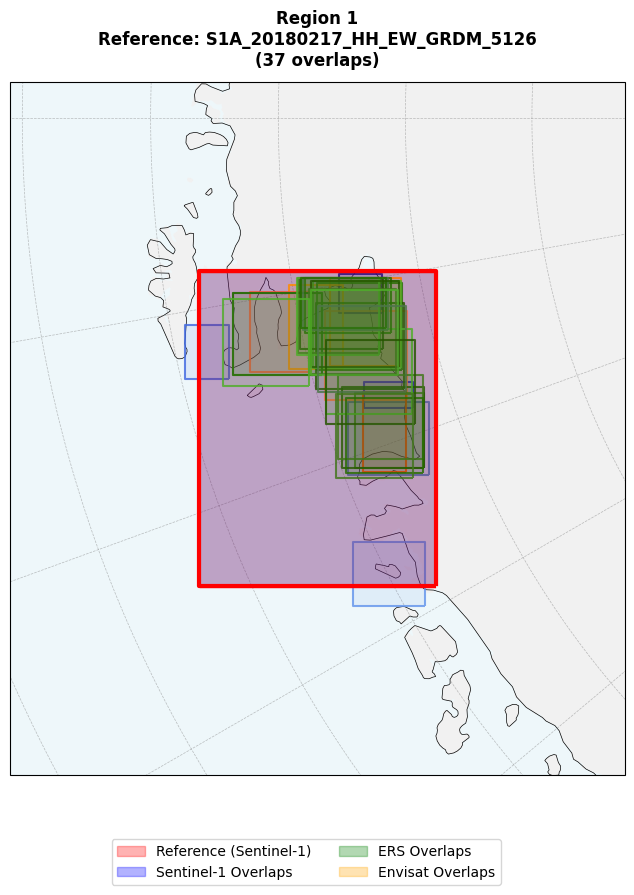

In [8]:
# === Plot Region 1 separately (the one with 37 overlaps) ===
region_name = 'Region 1'
region_data = regions[region_name]

fig_r1 = plt.figure(figsize=(9, 9))
ax_r1 = fig_r1.add_subplot(1, 1, 1, projection=antarctic_proj)

# Load reference scene
ref_gdf = load_shapefile(
    region_data['reference']['folder'],
    region_data['reference']['satellite'],
    region_data['reference']['filename']
)
if ref_gdf is not None:
    ref_gdf = ref_gdf.to_crs(antarctic_proj)
    ref_gdf.boundary.plot(ax=ax_r1, color='red', linewidth=3, zorder=10)
    ref_gdf.plot(ax=ax_r1, facecolor='red', alpha=0.15, edgecolor='red', linewidth=2.5, zorder=10)

# Plot overlapping scenes
satellite_colors = {
    'Sentinel-1': ['blue', 'darkblue', 'steelblue', 'cornflowerblue', 'royalblue'],
    'ERS': ['green', 'darkgreen', 'forestgreen', 'limegreen', 'seagreen'],
    'Envisat': ['orange', 'darkorange', 'coral', 'tomato', 'orangered']
}
sat_indices = {'Sentinel-1': 0, 'ERS': 0, 'Envisat': 0}

for folder, satellite, filename in region_data['overlapping']:
    overlap_gdf = load_shapefile(folder, satellite, filename)
    if overlap_gdf is None:
        continue
    overlap_gdf = overlap_gdf.to_crs(antarctic_proj)

    colors = satellite_colors[satellite]
    color = colors[sat_indices[satellite] % len(colors)]
    sat_indices[satellite] += 1

    overlap_gdf.boundary.plot(ax=ax_r1, color=color, linewidth=1.5, alpha=0.8, zorder=5)
    overlap_gdf.plot(ax=ax_r1, facecolor=color, alpha=0.1, edgecolor=color, linewidth=1.2, zorder=5)

# Add Antarctic features
ax_r1.coastlines(resolution='50m', linewidth=0.5, color='black', zorder=1)
ax_r1.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3, zorder=0)
ax_r1.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.2, zorder=0)
ax_r1.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--', zorder=2)

# Title and extent (zoomed out a bit more)
ref_filename = region_data['reference']['filename'].replace('.shp', '')
ax_r1.set_title(f"{region_name}\nReference: {ref_filename}\n(37 overlaps)",
                fontsize=12, fontweight='bold', pad=12)

# Set extent using bounding box of the reference + buffer
if ref_gdf is not None:
    bounds = ref_gdf.total_bounds
    buffer = max(bounds[2]-bounds[0], bounds[3]-bounds[1]) * 0.6  # zoom out more
    ax_r1.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
    ax_r1.set_ylim(bounds[1] - buffer, bounds[3] + buffer)

# Add legend
legend_elements = [
    mpatches.Patch(facecolor='red', edgecolor='red', alpha=0.3, label='Reference (Sentinel-1)'),
    mpatches.Patch(facecolor='blue', edgecolor='blue', alpha=0.3, label='Sentinel-1 Overlaps'),
    mpatches.Patch(facecolor='green', edgecolor='green', alpha=0.3, label='ERS Overlaps'),
    mpatches.Patch(facecolor='orange', edgecolor='orange', alpha=0.3, label='Envisat Overlaps')
]
fig_r1.legend(handles=legend_elements, loc='lower center', ncol=2,
              fontsize=10, frameon=True, bbox_to_anchor=(0.5, -0.02))

# Save and show
output_path_r1 = 'region1_37_overlaps.png'
plt.savefig(output_path_r1, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\nFigure saved to: {output_path_r1}")

plt.show()


Error: Image not found at --f=/run/user/7055426/jupyter/runtime/kernel-v316736945b0f0ec34f44f618aae41841eaeecf54d.json

Usage: python bbox_selector.py <path_to_overlap_image>


SystemExit: 1

/home/users/amorgan/benchmark_CB_AM/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
